# Analysis of accuracy and speed of stochastic simulation libraries

<!--TABLE OF CONTENTS-->
Contents:
- [Functions](#Functions)
- [Models](#Models)
    - [System 1: Birth-death process](#System-1:-Birth-death-process)
    - [System 2: Immigration-death process](#System-2:-Immigration-death-process)
    - [System 3: Dimerization](#System-3:-Dimerization)
    - [System 4: Batch immigration-death process](#System-4:-Batch-immigration-death-process)
- [Accuracy](#Accuracy)
    - [Exact simulations](#Exact-simulations)
    - [Approximate simulations](#Approximate-simulations)
    - [Example plot](#Example-plot)
    - [Direct](#Direct)
    - [Tau leaping](#Tau-leaping)
    - [Tau adaptive](#Tau-adaptive)
    - [Overall take homes](#Overall-take-homes)
- [Speed](#Speed)
- [Speed vs. accuracy comparison](#Speed-vs.-accuracy-comparison)
- [What algorithm to use?](#What-algorithm-to-use?)

In [14]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pathlib
from IPython.display import Image
from brokenaxes import brokenaxes


sns.set_style("whitegrid")

---
## Functions

In [2]:
from utils import (
    make_accuracy_df,
    make_benchmark_df,
    plot_accuracy_barplot,
    plot_benchmark_barplot,
    LIB_PALETTE,
    ALGO_PALETTE,
)

---
## Models

To compare the accuracies of the algorithms, we used a subset of the models recommended in the [SBML test suite's stochastic component](https://github.com/sbmlteam/sbml-test-suite/blob/master/cases/stochastic/DSMTS-userguide-31v2.pdf). They consist of 4 systems with different parameter combinations, resulting in a total of 14 models or 14 system-parameter combinations. The systems and parameter combinations are outlined below.

### System 1: Birth-death process

This model involves one species $\mathbf{X}$ and consists of the following reactions:
$$\textit{birth: } \mathbf{X} \xrightarrow{\lambda} 2\mathbf{X} $$
$$\textit{death: } \mathbf{X} \xrightarrow{\mu} \varnothing $$

#### Models

| Model ID | $X[0]$ | $\lambda$ | $\mu$ |
|:--------:|:------:|:---------:|-------|
|   00001  | 100    |    0.1    | 0.11  |
|   00003  | 100    |    1.0    | 1.1   |
|   00004  | 10     |    0.1    | 0.11  |
|   00005  | 10000  |    0.1    | 0.11  |
|   00011  | 100    |    0.0    | 0.055 |

### System 2: Immigration-death process

This model involves one species $\mathbf{X}$ and consists of the following reactions:
$$ \textit{immigration: } \varnothing \xrightarrow{\alpha} \mathbf{X} $$
$$ \textit{death: } \mathbf{X} \xrightarrow{\mu} \varnothing $$

#### Models

| Model ID |$$X[0]$$| $\alpha$ | $\mu$ |
|:--------:|:------:|:--------:|-------|
|   00020  | 0.0    |    1.0   | 0.1   |
|   00021  | 0.0    |   10.0   | 0.1   |
|   00022  | 0.0    |    5.0   | 0.1   |
|   00023  | 0.0    |   1000   | 0.1   |

### System 3: Dimerization

This model involves two species $\mathbf{X}$, $\mathbf{X_2}$ and consists of the following reactions:

$$ \textit{dimerization: } 2\mathbf{X} \xrightarrow{k_1} \mathbf{X_2} $$
$$ \textit{dissociation: } \mathbf{X_2} \xrightarrow{k_2} 2\mathbf{X} $$

>NOTE:
>The dimerization reaction is second order

#### Models

| Model ID |$$X[0]$$|$$X_2[0]$$| $k_1$  | $k_2$ |
|:--------:|:------:|:--------:|--------|-------|
|   00030  | 100    |     0    | 0.001  | 0.01  |
|   00031  | 1000   |     0    | 0.0002 | 0.004 |

### System 4: Batch immigration-death process

This model involves one species $\mathbf{X}$ and consists of the following reactions:
$$ \textit{immigration: } \varnothing \xrightarrow{\alpha} K\mathbf{X} $$
$$ \textit{death: } \mathbf{X} \xrightarrow{\mu} \varnothing $$

#### Models

| Model ID | $$X[0]$$ | $K$ | $\alpha$ | $\mu$ |
|:--------:|:--------:|:---:|:--------:|-------|
|   00037  |    0.0   |  5  |    1.0   | 0.2   |
|   00038  |    0.0   |  10 |    1.0   | 0.4   |
|   00039  |    0.0   | 100 |    1.0   | 4.0   |

---
## Accuracy

In order to test the accuracy of the libraries and algorithms we perform 10,000 independent simulations of a model.The simulated results are compared with analytical results at t=0,1,...,50 to obtain the accuracy.
The following equations were used to test for the accuracy. The equations are different for the exact and approximate algorithms, as recommended by the [SBML Test Suite](https://github.com/sbmlteam/sbml-test-suite).

### Exact simulations

Two test statistics are used to score the accuracy, $Z_t$ and $Y_t$.

$$ Z_t \equiv \sqrt{n} \left( \frac{\hat{X}_t - \mu_t}{\sigma_t} \right) $$
$$ Y_t \equiv \sqrt{\frac{n}{2}} \left( \frac{\hat{S}^2_t}{\sigma^2_t} - 1 \right) $$


Symbol | Parameter
--- | ---
$\mu_t$ | Analytical mean of species counts at time $t$
$\sigma_t$ | Analytical standard deviation of species counts at time $t$
$\hat{X}_t$ | Observed mean of species counts at time $t$
$\hat{S}_t$ | Observed standard deviation of species counts at time $t$
$n$ | Number of repetitions of the simulations to generate the sample

$Z_t$ is expected to fall in the interval [-3, 3], whereas $Y_t$ is expected to fall in the interval [-5, 5].

#### Score

We computed the accuracy score as the percentage of times $Z_t$ and $Y_t$ fall in their expected intervals. For models with a single species, there are 50 mean tests + 50 std. dev. tests, since there are 50 time points. For models with two species, there are 100 mean tests + 100 std. dev. tests.

### Approximate simulations

$$ A_t = \hat{X}_t / \mu_t $$
$$ B_t = \hat{S}_t / \sigma_t $$

$A_t$ and $B_t$ are expected to fall in the interval [0.98, 1.02]. 

#### Score

We computed the accuracy score as the percentage of times $A_t$ and $B_t$ fall in their expected intervals. For models with a single species, there are 50 mean tests + 50 std. dev. tests, since there are 50 time points. For models with two species, there are 100 mean tests + 100 std. dev. tests.

### Example plot

Below is an example of what these statistics look like overlaid with a summary of the simulations themselves.
1. In the top left panel, analytical means ($\mu_t$) are plotted as circles and observed means ($\hat{X}_t$) are plotted as the blue line. Green circles indicate points where $Z_t$ falls in it's desired interval. Red circles indcate $Z_t$ outside it's desired interval.
1. In the top right panel, analytical std. devs. ($\sigma_t$) are plotted as circles and observed std. devs. are plotted as the blue line ($\hat{S}_t$). Green circles indicate points where $Y_t$ falls in it's desired interval. Red circles indcate $Y_t$ outside it's desired interval.
1. In the bottom left panel, the ratio of means ($A_t$) is plotted. Green circles indicate $A_t$ falls in its desired interval while red circles indicate it falls outside the desired interval.
1. In the bottom right panel, the ratio of means ($B_t$) is plotted. Green circles indicate $B_t$ falls in its desired interval while red circles indicate it falls outside the desired interval.

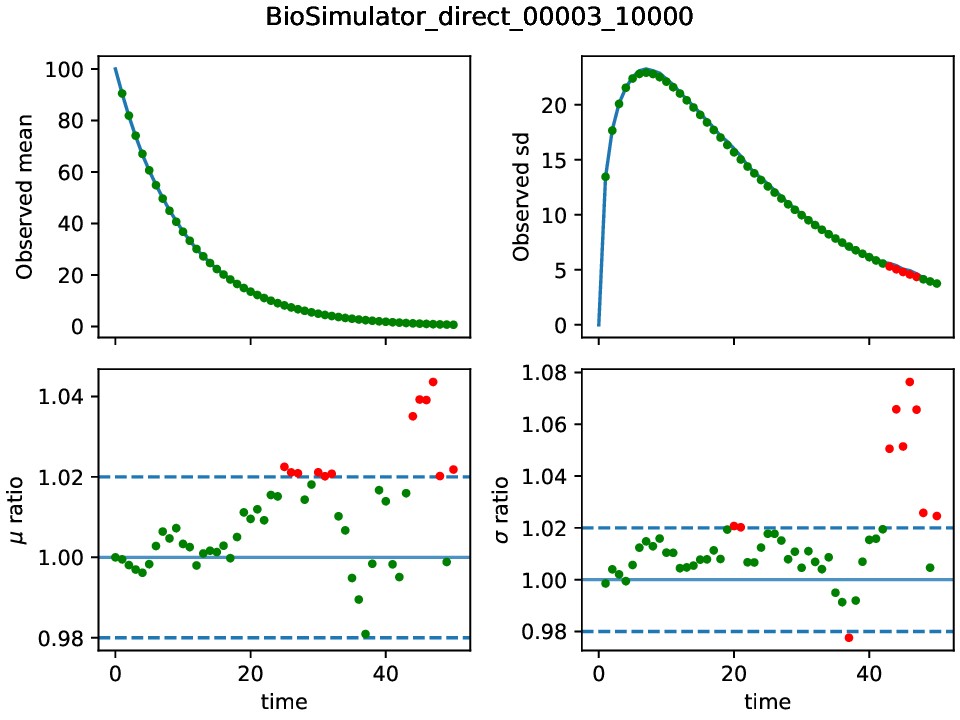

In [3]:
Image(filename="BioSimulator_direct_00003_10000.png") 

In [4]:
# read accuracy data
cayenne_results = make_accuracy_df("cayenne_results.csv")
tellurium_results = make_accuracy_df("Tellurium_results.csv")
biosimulator_results = make_accuracy_df("BioSimulator_results.csv")
biosimulatorintp_results = make_accuracy_df("BioSimulatorIntp_results.csv")
gillespiessa_results = make_accuracy_df("GillespieSSA_results.csv")
accuracy_results = pd.concat(
    [cayenne_results, tellurium_results, biosimulator_results, biosimulatorintp_results, 
     gillespiessa_results]
)

In [5]:
accuracy_results.head()

,model,lib,algo,nrep,test0,test1,test2,test3,rtest0,rtest1,rtest2,rtest3,nspecies,ntest,total_pass
0,00004,cayenne,direct,10000,0,0,0,0,0,0,0,0,1,100,100.0
1,00004,cayenne,tau_adaptive,10000,0,0,0,3,0,0,0,10,1,100,90.0
2,00001,cayenne,direct,10000,0,0,0,0,0,0,0,0,1,100,100.0
3,00001,cayenne,tau_leaping,10000,0,0,0,0,0,0,0,0,1,100,100.0
4,00001,cayenne,tau_adaptive,10000,0,0,0,0,0,0,0,2,1,100,98.0


### Direct

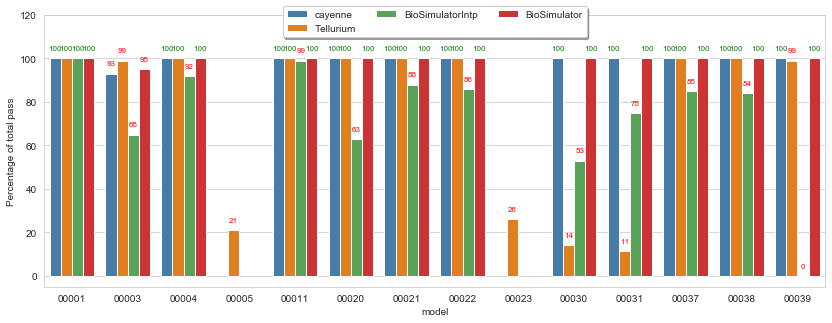

In [6]:
plot_accuracy_barplot(accuracy_results[accuracy_results.algo == "direct"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | No | n/a
00003 | Yes, all | Even the C library says it will fail
00004 | Yes, BioSimulatorIntp | BioSimulatorIntp (BioSimulator internal interpolation not accurate)
00005 | DNF, all | Tellurium is probably not doing direct
00011 | No | n/a (99 is okay) 
00020 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00021 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00022 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00023 | DNF, all | Tellurium is probably not doing direct
00030 | Yes, Tellurium, BiosimulatorIntp | Tellurium fails even when rate expression is hardcoded as per `sbml-test-suite`. BiosimulatorIntp fails at high slope and low slope regions.
00031 | Yes, Tellurium, BiosimulatorIntp |  Tellurium fails even when rate expression is hardcoded as per `sbml-test-suite`. BiosimulatorIntp fails at high slope/quick change regions.
00037 | Yes, BiosimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00038 | Yes, BiosimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00039 | Yes, , BiosimulatorIntp | Fails completely because it returns an incorrect steady state.

#### Take-homes

1. The direct algorithm in cayenne, BioSimulator.jl and Tellurium are accurate in general.
2. BioSimulator does better than BioSimulatorIntp. What this means is that inteprolation with the cayenne's backend is better than interpolation in BioSimulator's backend.  
  1. So, even though the algorithm itself is implemented correctly, retrieving results at specified time points may require careful handling to maintain accuracy.
3. Tellurium's output for second order reactions are inaccurate.

#### Notes

1. Models 00005 and 00023 did not finish running (DNF) in the time they were allotted. This is because molecule counts increase exponentially, making the direct algorithm take shorter and shorter time steps.
2. All algorithms perform relatively less well for model 00003. This has been observed elsewhere for this model (for example https://github.com/sys-bio/libStochastic/blob/446e569ea9d3d94c2df48245a80a603437e4da5e/Python/testdsmts.py#L40).
3. We did not run GillespieSSA here since it was prohibitively slow.


### Tau leaping

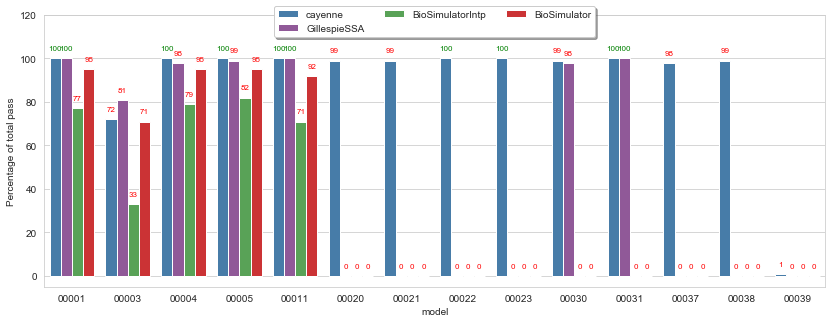

In [7]:
plot_accuracy_barplot(accuracy_results[accuracy_results.algo == "tau_leaping"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00003 | Yes, all | Even the C library says it will fail. BioSimulatorIntp is worse.
00004 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00005 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00011 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00020 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00021 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00022 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA  | All fail because of 0 species. 
00023 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA  | All fail because of 0 species.
00030 | Yes, Biosimulator, BiosimulatorIntp  | All fail because one species is 0.
00031 | Yes, Biosimulator, BiosimulatorIntp | All fail because one species is 0.
00037 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00038 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00039 | Yes, all | Biosimulator, BiosimulatorIntp and GillespieSSA fails because of 0 species. `cayenne` fails, likely because of high tau. BioSimulator converges to the wrong mean value, but the model seems right (since it was copied and modified from 37, 38 and those converge to correct value. Strangely BioSimulator SD converges)

>NOTE:
>These results use $\mu$ and $\sigma$ ratios as the test statistic

#### Take-homes
1. cayenne's tau-leaping performs pretty well except for stiff systems.
2. Other libraries' tau-leaping failed to simulate for various cases
  1. GillespieSSA exits the simulation when all of the initial species are 0.
  1. BioSimualtor exits the simulation when any of the initial species is 0.
1. BioSimulator's tau_leaping is not as accurate as GillespieSSA's or cayenne's. This is for cases when none of them exit the simulation.

### Tau adaptive


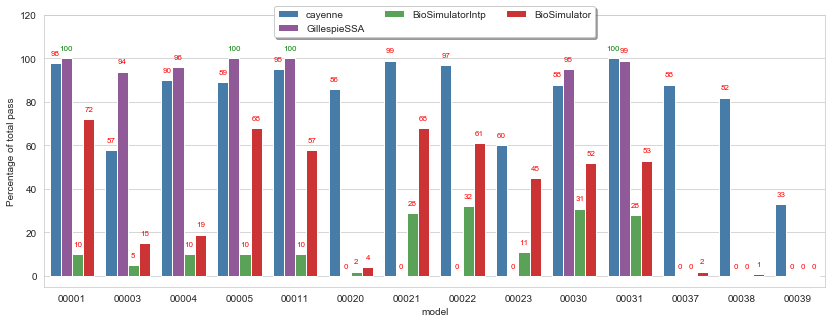

In [8]:
plot_accuracy_barplot(accuracy_results[accuracy_results.algo == "tau_adaptive"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | Yes, Biosimulator and BiosimulatorIntp | SD (ratio) is lower than expected
00003 | Yes, cayenne, Biosimulator and BiosimulatorIntp | Mean and SD (ratios) are higher than expected
00004 | Yes, Biosimulator and BiosimulatorIntp | Mean is high and SD is lower than expected
00005 | Yes, Biosimulator and BiosimulatorIntp | SD is lower than expected
00011 | Yes, Biosimulator and BiosimulatorIntp | SD is lower than expected
00020 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | Gillespie fails because of 0 species. Mean and SD ratios are randomly fluctuating
00021 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | Gillespie fails because of 0 species. SD is higher than expected
00022 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | Gillespie fails because of 0 species. SD is higher than expected
00023 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.
00030 | Yes, cayenne, Biosimulator and BiosimulatorIntp | Deviation in mean and SD ratios.
00031 | Yes, Biosimulator and BiosimulatorIntp | High SD ratios.
00037 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.
00038 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.
00039 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.


#### Take-homes

1. GillespieSSA's and cayenne's tau adaptive algorithms perform well, with GillespieSSA doing better usually.
  1. GillespieSSA still fails to simulate when all of the initial species are 0.
1. BioSimulator's tau adaptive performs poorly.

>NOTE:
>These results use $\mu$ and $\sigma$ ratios as the test statistic

### Overall take homes

- The tau-adaptive algorithms are in general less accurate than direct and tau-leaping algorithms.
- `GillespieSSA` performs better than `cayenne` or `BioSimulator.jl` in general.
    - But `GillespieSSA` fails to simulate in cases with zero initial species.

---

## Speed

To compare the speed of the different algorithms, we used a subset of models (5 of the 14) used for the accuracy comparisons. These were picked to represent the general breadth of models, with at least one coming from each of the 4 different systems (see under Models above).


1. A given model, for a given algorithm from a library, was run 10000 times and the time taken was noted.
1. This was repeated 7 times, to get an idea of the variance in the simulation time.
1. All simulations were run on single cores.
1. Speed was calculated as the inverse of the time taken in seconds for the algorithm to run to completion.

Below is an example of what the results of the speed benchmarking looks like.


In [9]:
# read benchmark data
benchmark_results = make_benchmark_df("../benchmarks/")
benchmark_results.head()

,command,mean,stddev,median,user,system,min,max,times,lib,algo,model,nrep
0,julia biosimjl_test/make_biosim_results.jl 000...,6.992687,0.252884,6.919580,6.703583,0.648562,6.830754,7.541846,"[7.54184570085, 6.83075350485, 6.85326590585, ...",BioSimulator,direct,00001,10000
1,julia biosimjl_test/make_biosim_results.jl 000...,8.949872,0.072271,8.945051,8.329951,1.054672,8.874817,9.094799,"[8.87481668838, 8.94505102138, 9.0947985563799...",BioSimulator,direct,00003,10000
2,julia biosimjl_test/make_biosim_results.jl 000...,7.037875,0.142517,6.961350,6.764233,0.695744,6.912390,7.311989,"[6.9613495557250005, 6.959481002725, 7.1365935...",BioSimulator,direct,00021,10000
3,julia biosimjl_test/make_biosim_results.jl 000...,5.598100,0.093141,5.572237,5.592395,0.418798,5.487920,5.740631,"[5.551804434615, 5.487919591615, 5.57223690461...",BioSimulator,direct,00030,10000
4,julia biosimjl_test/make_biosim_results.jl 000...,6.329847,0.085929,6.332444,6.202522,0.544836,6.216229,6.460468,"[6.460467532435, 6.343335806435, 6.40198515743...",BioSimulator,direct,00038,10000


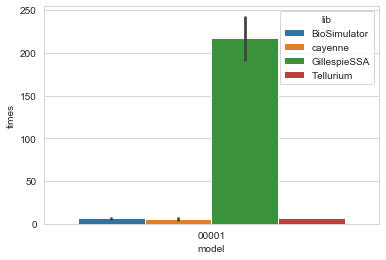

In [10]:
plot_benchmark_barplot(benchmark_results[benchmark_results.model == "00001"])

> Note : The above is  plot of the times. This is the inverse of speed.

---
## Speed vs. accuracy comparison

The speed results are best contextualized with the accuracy results, since an algorithm that fails to simulate can run quickly - but this does not tell us about its performance.

Below we present accuracy on the X axis and speed on the Y axis. Desirable algorithms will occupy the top right corner of the plot. Of course, an algorithms must meet some accuracy threshold to qualify for a meaningful speed comparison.

In [11]:
acc_speed_results = benchmark_results.merge(accuracy_results, how="inner", on = ["lib", "algo", "model"])

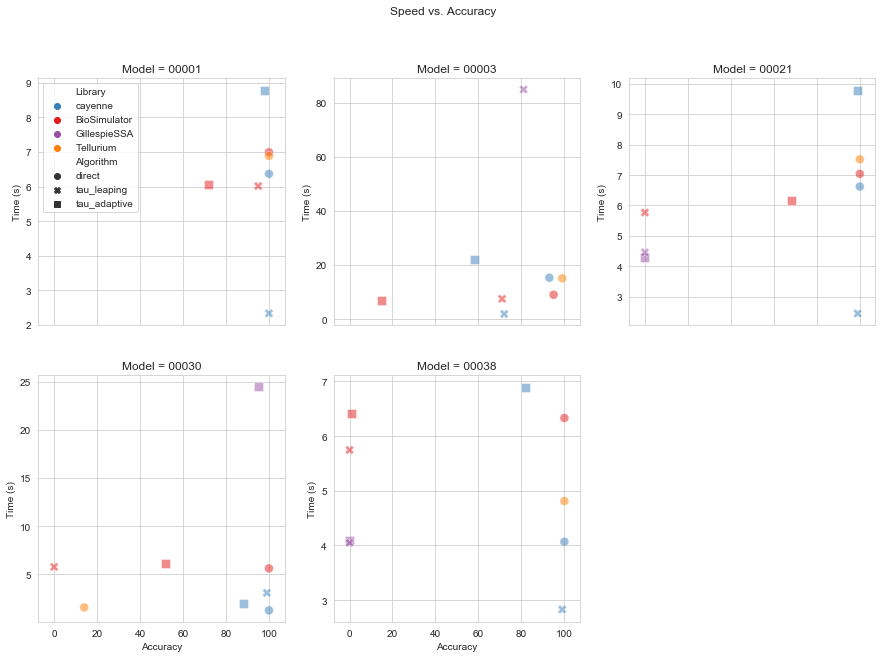

In [21]:
acc_speed_results["Accuracy"] = acc_speed_results["total_pass"]
acc_speed_results["Time"] = acc_speed_results["mean"]
acc_speed_results["Library"] = acc_speed_results["lib"]
acc_speed_results["Algorithm"] = acc_speed_results["algo"]

models = sorted(set(list(acc_speed_results.model)))
this_filter = (acc_speed_results.model == models[0])
marker_size = 80
fig, ax = plt.subplots(2,3,sharex=True, figsize=([15,10]))
fig.suptitle("Speed vs. Accuracy")
fig.delaxes(ax[1][2])

hue_order = ["cayenne", "BioSimulator", "GillespieSSA", "Tellurium"]
style_order = ["direct", "tau_leaping", "tau_adaptive"]

p = [None] * len(models)
for ind, this_model in enumerate(models):
    this_filter = (acc_speed_results.model == this_model) & (acc_speed_results.Time < 100)
    this_ax = ax[ind//3, ind%3]
    this_ax.set_title(f"Model = {this_model}")
    if ind == 0:
        p[ind] = sns.scatterplot(x="Accuracy", y="Time", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=LIB_PALETTE,
                        ax = this_ax, alpha=0.5)
    else:
        p[ind] = sns.scatterplot(x="Accuracy", y="Time", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=LIB_PALETTE,
                        ax = this_ax, legend=False, alpha=0.5)
    this_ax.set_ylabel("Time (s)")

fig.savefig("../assets/acc_speed_comparison_all.png")

AttributeError: 'list' object has no attribute 'get_sizes'

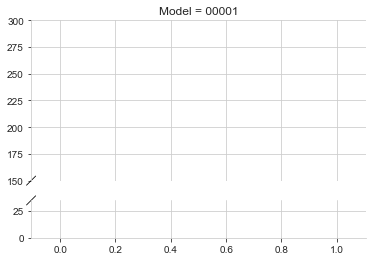

In [19]:
acc_speed_results["Accuracy"] = acc_speed_results["total_pass"]
acc_speed_results["Time"] = acc_speed_results["mean"]
acc_speed_results["Library"] = acc_speed_results["lib"]
acc_speed_results["Algorithm"] = acc_speed_results["algo"]

models = sorted(set(list(acc_speed_results.model)))
this_filter = (acc_speed_results.model == models[0])
marker_size = 80

from matplotlib.gridspec import GridSpec

s = GridSpec(2,3)

# fig, ax = plt.subplots(2,3,sharex=True, figsize=([15,10]))
# fig.suptitle("Speed vs. Accuracy")
# fig.delaxes(ax[1][2])

hue_order = ["cayenne", "BioSimulator", "GillespieSSA", "Tellurium"]
style_order = ["direct", "tau_leaping", "tau_adaptive"]

p = [None] * len(models)
for ind, this_model in enumerate(models):
    this_filter = (acc_speed_results.model == this_model)
    bax = brokenaxes(ylims=((0, 35), (150, 300)))
#     this_ax = ax[ind//3, ind%3]
    bax.set_title(f"Model = {this_model}")
    if ind == 0:
#         p[ind] = sns.scatterplot(x="Accuracy", y="Time", hue="Library", style="Algorithm", 
#                         data=acc_speed_results[this_filter], s=marker_size,
#                         hue_order=hue_order, style_order=style_order, palette=LIB_PALETTE,
#                         ax = bax, alpha=0.5)
        x = acc_speed_results[this_filter, "Accuracy"]
        y = acc_speed_results[this_filter, "Accuracy"]
        bax.plot(ac)
    else:
        p[ind] = sns.scatterplot(x="Accuracy", y="Time", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=LIB_PALETTE,
                        ax = bax, legend=False, alpha=0.5)

# fig.savefig("../assets/acc_speed_comparison_all.png")

## What algorithm to use?

We provide a high level summary from the speed and accuracy comparisons. The table below should help a practioner in deciding between the different libraries and algorithms therein.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg th{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-green{background-color:#c6e0b4;border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-orange{background-color:#ffe685;border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-73oq{border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-red{background-color:#f4b084;border-color:#000000;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax"></th>
    <th class="tg-0lax">direct</th>
    <th class="tg-0lax">tau_leaping</th>
    <th class="tg-0lax">tau_adaptive</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">cayenne</td>
    <td class="tg-green">Most   accurate yet</td>
    <td class="tg-green">Very fast but may need manual tuning</td>
    <td class="tg-orange">Less   accurate than GillespieSSA's version</td>
  </tr>
  <tr>
    <td class="tg-0lax">Tellurium</td>
    <td class="tg-orange">Inaccurate   for 2nd order</td>
    <td class="tg-73oq">N/A</td>
    <td class="tg-73oq">N/A</td>
  </tr>
  <tr>
    <td class="tg-0lax">GillespieSSA</td>
    <td class="tg-orange">Accurate but very slow</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
  </tr>
  <tr>
    <td class="tg-0lax">BioSimulator.jl</td>
    <td class="tg-orange">Inaccurate   interpolation</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
  </tr>
</tbody>
</table>

In [13]:
this_filter = (acc_speed_results.model == "00001")
p[ind] = sns.scatterplot(x="Accuracy", y="Speed", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=LIB_PALETTE,
                        alpha=0.5)
plt.xlim(-5, 105)
plt.savefig("../assets/acc_speed_comparison_example.png")
plt.close()